In [1]:
import numpy as np
from Functions.propagator import *
from Functions.utils import *
from Functions.fourier_mask import *
import matplotlib.pyplot as plt

def cart2pol(x, y):
    r = np.hypot(x, y)
    theta = np.arctan2(y, x)
    return r, theta

def CreateTelescopePupil_physical(Npx, radius, extent):
    x = np.linspace(-extent/2, extent/2, Npx)  # incluye extremos
    X, Y = np.meshgrid(x, x, indexing='ij')
    R = np.sqrt(X**2 + Y**2)
    return (R <= radius)

def CreateTelescopePupil(Npx):
    x = np.arange(-(Npx-1)/2, (Npx-1)/2 + 1, 1)  # Npx puntos, centro entre píxeles
    x = x / np.max(x)
    u = v = x
    X, Y = np.meshgrid(u, v, indexing='ij')
    r, _ = cart2pol(X, Y)
    return (r <= 1)

def center_pad(arr, N_target):
    assert arr.ndim == 2
    N0 = arr.shape[0]
    d = N_target - N0
    p0 = d // 2
    p1 = d - p0
    return np.pad(arr, ((p0, p1), (p0, p1)), mode='constant', constant_values=0)

# --- tu caso: 128 -> 512 --- minimo 4??
N0 = 128*1
N1 = N0*4
pupil_128 = CreateTelescopePupil(N0)
pupil_512_from_pad = center_pad(pupil_128, N1)

extent = (4 + N0/64) * mm#4. * mm   # el que tú quieras (mm, m, lo que uses)
radius = (extent/2) * (N0-1)/(N1-1)  # == extent * 63.5 / 511

print(extent)
print(radius)

pupil_512_physical = CreateTelescopePupil_physical(N1, radius, extent)

Field = TorchField.begin(wavelength=635*nm, grid_size=extent, Npx=N1, precision='double', batch=1, device='cuda:7')
Field_aperture = Field.circ_aperture(R=radius)

field_ap = Field_aperture.field.squeeze().cpu().numpy()

print("¿Coinciden píxel a píxel?:", np.array_equal(pupil_512_from_pad, field_ap))


0.006
0.0007455968688845401
127.0
¿Coinciden píxel a píxel?: True


127.0


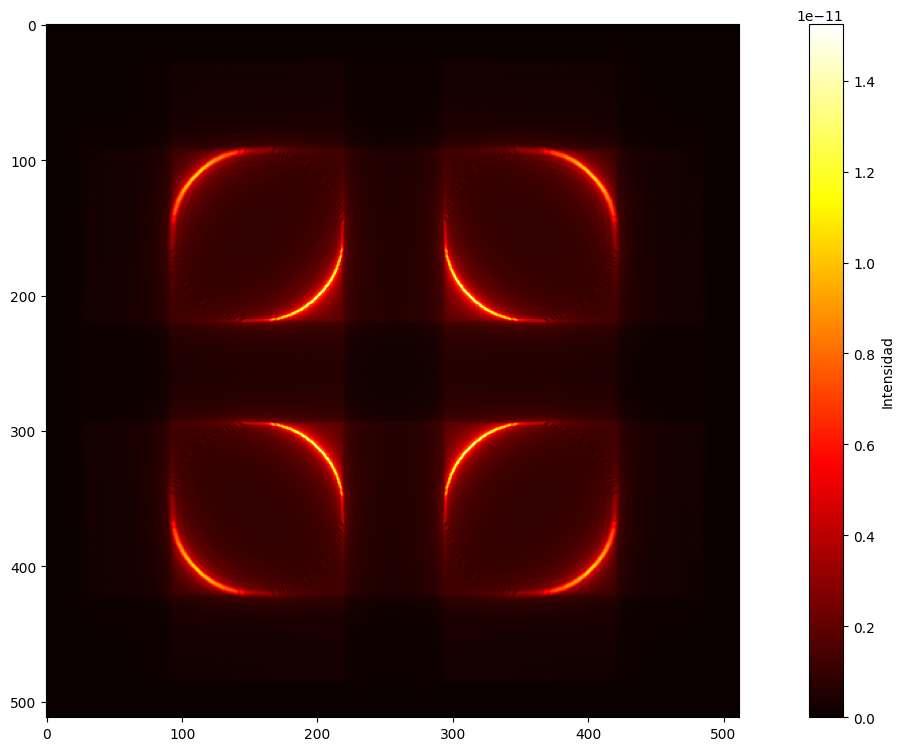

In [3]:


wavelength = 635 * nm  # 500 nm
size =  extent
N = N1
R = radius

fourier_mask, _ = fourier_geometry(alpha=3, nhead=4, resol=N)
fourier_mask = torch.fft.fftshift(fourier_mask)

Field = TorchField.begin(wavelength=wavelength, grid_size=size, Npx=N, precision='double', batch=1, device='cuda:7')
Field_aperture = Field.circ_aperture(R=R)

# Field_aperture = Field_aperture.apply_phase(phi)
# Field_aperture.field = Field_aperture.field * torch.exp(1j * torch.tensor(phi, device=Field_aperture.field.device, dtype=Field_aperture.field.dtype))

Field_propagated = Field_aperture.propagate_asm_pad(z = 10*cm)
Field_lens1 = Field_propagated.lens(f=10*cm)
Field_propagated = Field_lens1.propagate_asm_pad(z = 10*cm)
## PSF ##
Field_propagated.apply_mask(fourier_mask, inplace=True)
# F = F.apply_mask(fourier_mask)
## PSF ##
Field_propagated = Field_propagated.propagate_asm_pad(z = 10*cm)
Field_lens2 = Field_propagated.lens(f=10*cm)
Field_propagated = Field_lens2.propagate_asm_pad(z = 10*cm)

field_prop = Field_propagated.field.cpu().numpy()

plt.figure(figsize=(18, 9))
plt.imshow(np.abs(field_prop[0,:,:].squeeze())**2, cmap='hot')
plt.colorbar(label='Intensidad')
plt.show()

In [5]:
Field = TorchField.begin(wavelength=wavelength, grid_size=size, Npx=N, precision='double', batch=1, device='cuda:7')
Field_ap = Field.circ_aperture(R=R)


pupil_128 = CreateTelescopePupil(N0)
pupil_512_from_pad = center_pad(pupil_128, N1)

pupil_512_torch = (Field_ap.field[0,0].real > 0).detach().cpu().numpy()

print("Iguales:", np.array_equal(pupil_512_from_pad.astype(bool), pupil_512_torch.astype(bool)))


127.0
Iguales: True


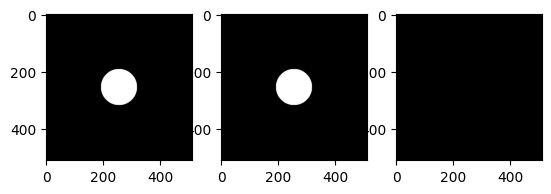

In [11]:
plt.subplot(1, 3, 1)
plt.imshow(pupil_512_from_pad, cmap='gray')

plt.subplot(1, 3, 2)
plt.imshow(pupil_512_torch, cmap='gray')

plt.subplot(1, 3, 3)
plt.imshow(np.float32(pupil_512_torch) - np.float32(pupil_512_from_pad), cmap='gray')

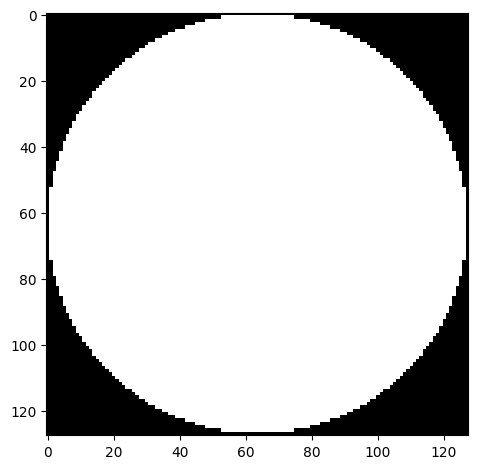

(128, 128)


In [14]:

plt.imshow(pupil_128, cmap='gray')

plt.tight_layout()
plt.show()
print(pupil_128.shape)
